In [1]:
import os
import numpy as np
import scipy.ndimage
import skimage.feature
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# https://www.programcreek.com/python/example/89295/cv2.bitwise_not
def img_fill(im_in, n):  # n = binary image threshold
    th, im_th = cv2.threshold(im_in, n, 255, cv2.THRESH_BINARY);

    # Copy the thresholded image.
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0, 0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    fill_image = im_th | im_floodfill_inv

    return fill_image

In [2]:
def em_color(img, ncolors=3):
    raw = img.reshape(-1,3)
    em = cv2.ml.EM_create()
    em.setClustersNumber(ncolors)
    em.trainEM(raw)
    means = em.getMeans()
    covs = em.getCovs()
    (r, prob) = em.predict(raw.astype(np.float32))
    colors = np.argmax(prob, axis=1).reshape(*img.shape[:2])
    return colors

In [10]:
bgr_imgs = [cv2.imread(f'imgs/{name}', cv2.IMREAD_COLOR) for name in sorted(os.listdir('imgs'))]
gray_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in bgr_imgs]
imgs_bboxes = np.load('imgs_bboxes.npy').item()

In [21]:
imgs_em_out = []
for img, (k, bboxes) in zip(bgr_imgs, imgs_bboxes.items()):
    img_out = 255*np.ones((img.shape[0], img.shape[1]))
    for bbox in bboxes:
        text = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        thr = 255*em_color(text, ncolors=2)
        if thr.mean() < 127:
            thr = 255 - thr 
        img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = thr 
        #plt.imshow(thr, cmap='gray')
        #plt.show()
    
    imgs_em_out.append(img_out)

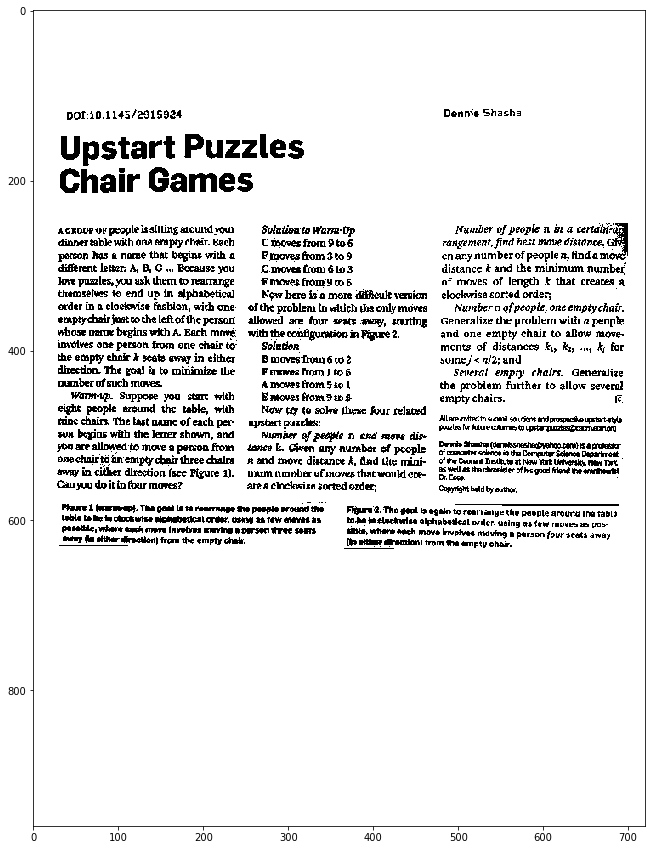

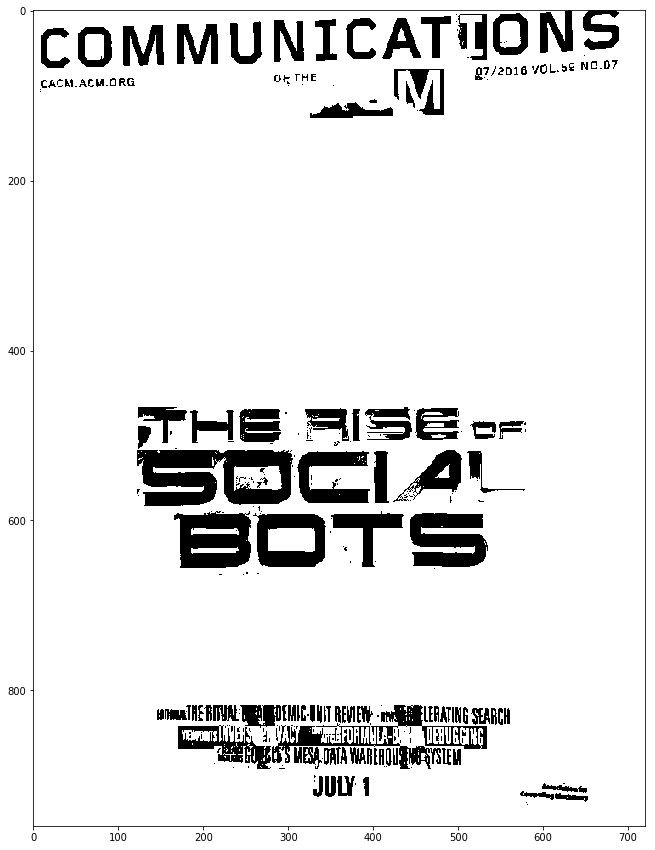

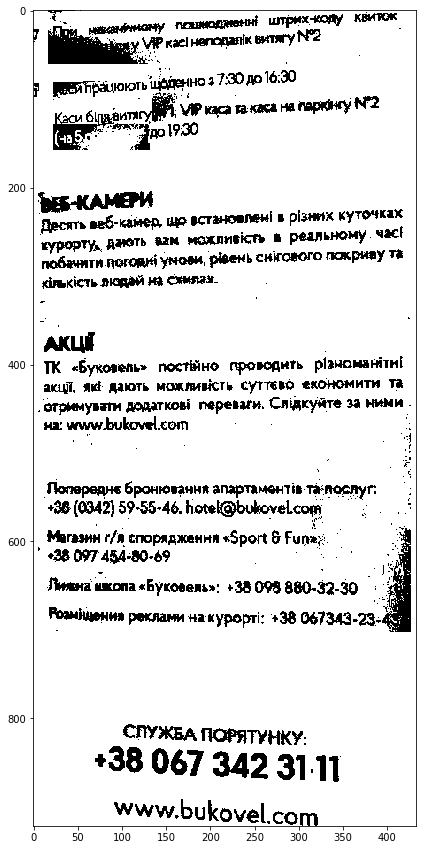

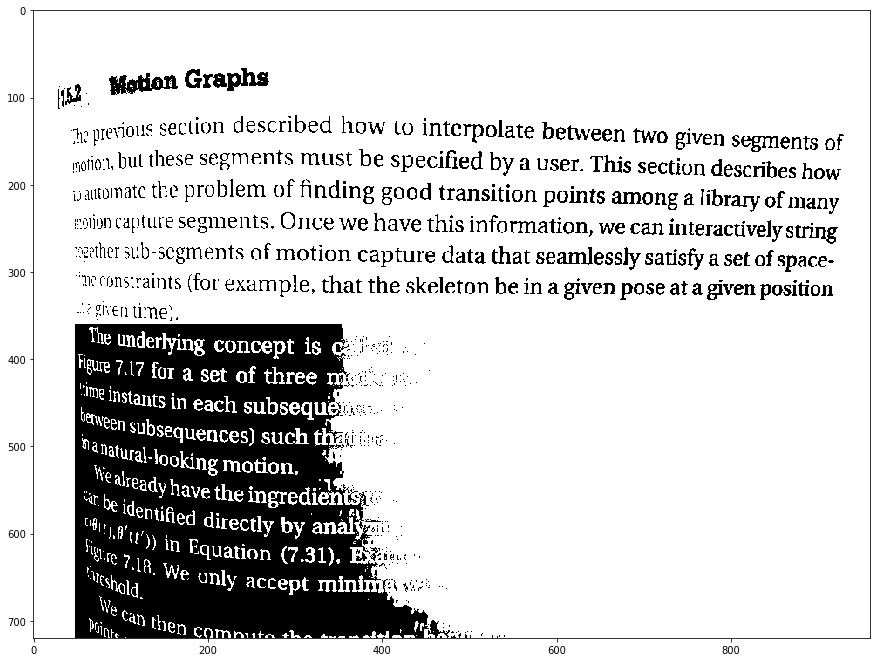

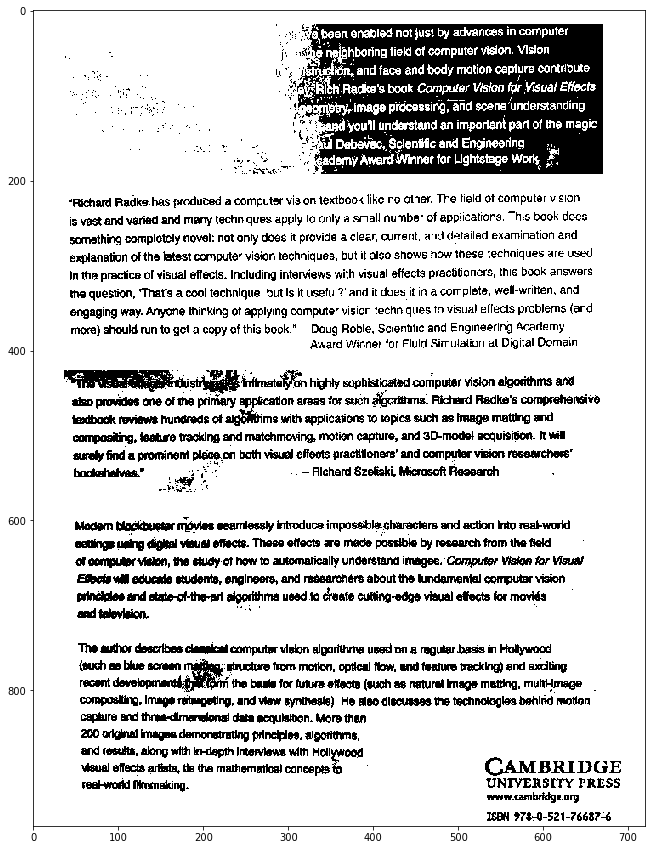

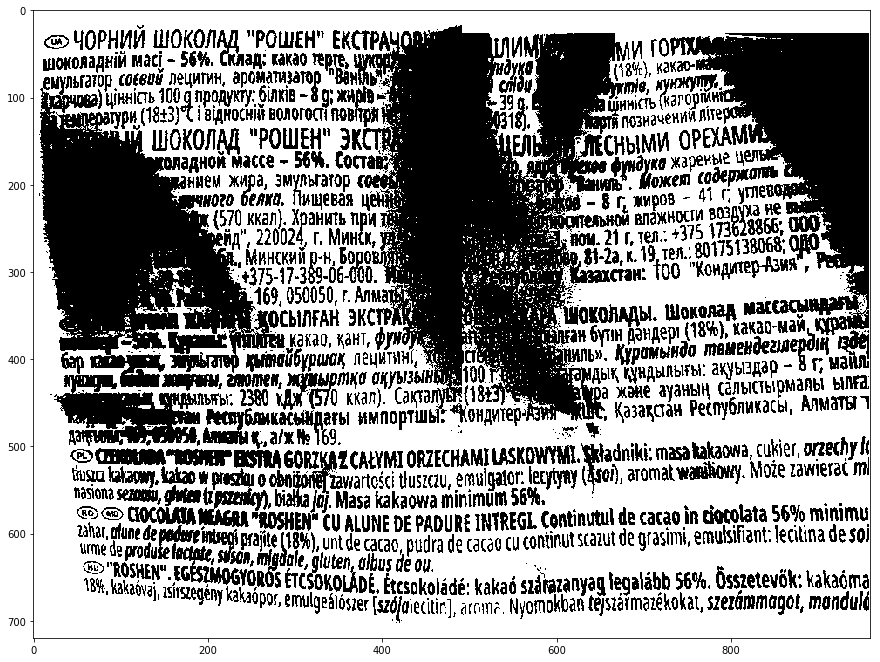

In [22]:
for img in imgs_em_out:
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
    plt.show()

In [164]:
imgs_out = []
for img, (k, bboxes) in zip(gray_imgs, imgs_bboxes.items()):
    img_out = 255*np.ones_like(img)
    for bbox in bboxes:
        text = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        _, thr = cv2.threshold(text, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        if thr.mean() < 127:
            thr = 255 - thr
        """
        if text.mean() < 127:
            text = 255 - text
        thr = cv2.adaptiveThreshold(text, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 1)
        """   
        img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = thr
        #plt.imshow(thr, cmap='gray')
        #plt.show()
    
    imgs_out.append(img_out)

In [165]:
def get_text(decision_boundary=127, max_value=255, flip_value=127):
    imgs_out = []
    for img, (k, bboxes) in zip(gray_imgs, imgs_bboxes.items()):
        img_out = 255*np.ones_like(img)
        for bbox in bboxes:
            text = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
            _, thr = cv2.threshold(text, decision_boundary, max_value, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            if thr.mean() < flip_value:
                thr = 255 - thr
            img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = thr
        imgs_out.append(img_out)
    
    plt.figure(figsize=(15,15))
    for k, img in enumerate(imgs_out):
        plt.subplot(3,2,k+1)
        plt.imshow(img, cmap='gray')
    
plot_text = interactive(get_text, decision_boundary=(0, 255, 1), max_value=(0, 255, 1), flip_value=(0, 255, 1))
plot_text

interactive(children=(IntSlider(value=127, description='decision_boundary', max=255), IntSlider(value=255, des…

In [166]:
def get_text(block_size=11, C=1, flip_value=127):
    imgs_out = []
    for img, (k, bboxes) in zip(gray_imgs, imgs_bboxes.items()):
        img_out = 255*np.ones_like(img)
        for bbox in bboxes:
            text = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
            if text.mean() < flip_value:
                text = 255 - text
            thr = cv2.adaptiveThreshold(text, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
            img_out[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] = thr
        imgs_out.append(img_out)
    
    plt.figure(figsize=(15,30))
    for k, img in enumerate(imgs_out):
        plt.subplot(3,2,k+1)
        plt.imshow(img, cmap='gray')
    
plot_text = interactive(get_text, block_size=(1, 31, 1), C=(0.1, 20., 0.1), flip_value=(0, 255, 1))
plot_text

interactive(children=(IntSlider(value=11, description='block_size', max=31, min=1), FloatSlider(value=1.0, des…

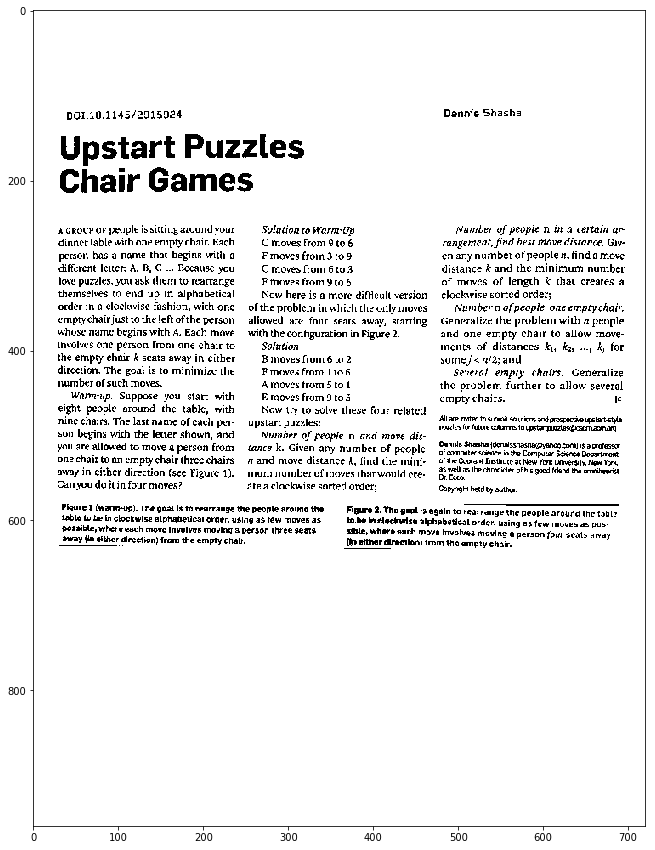

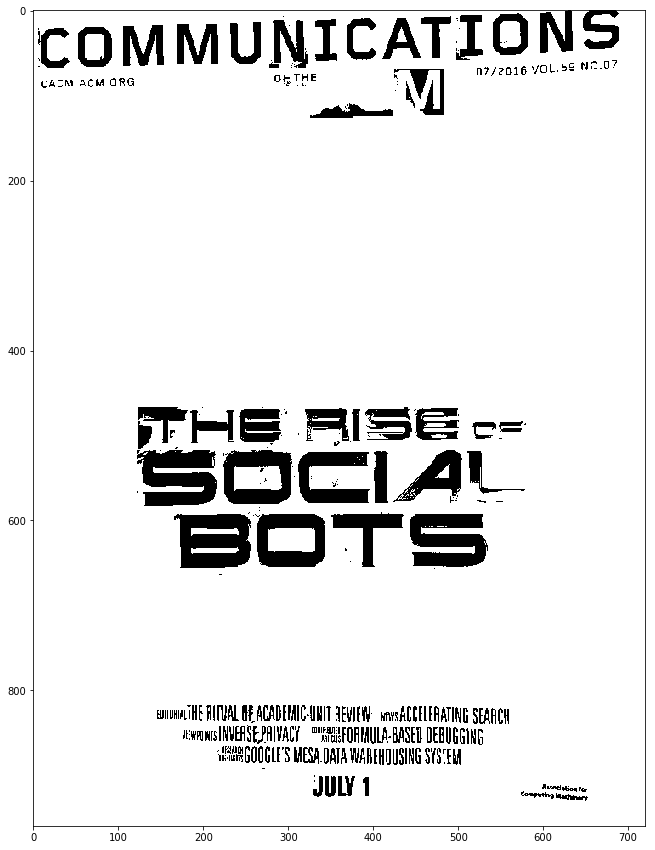

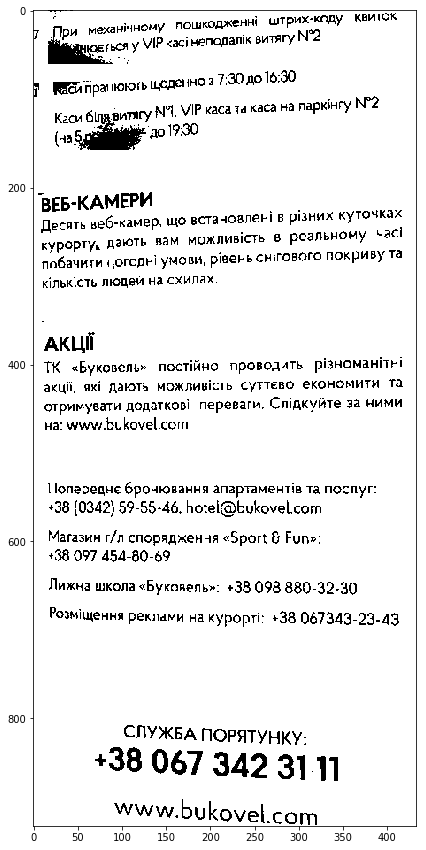

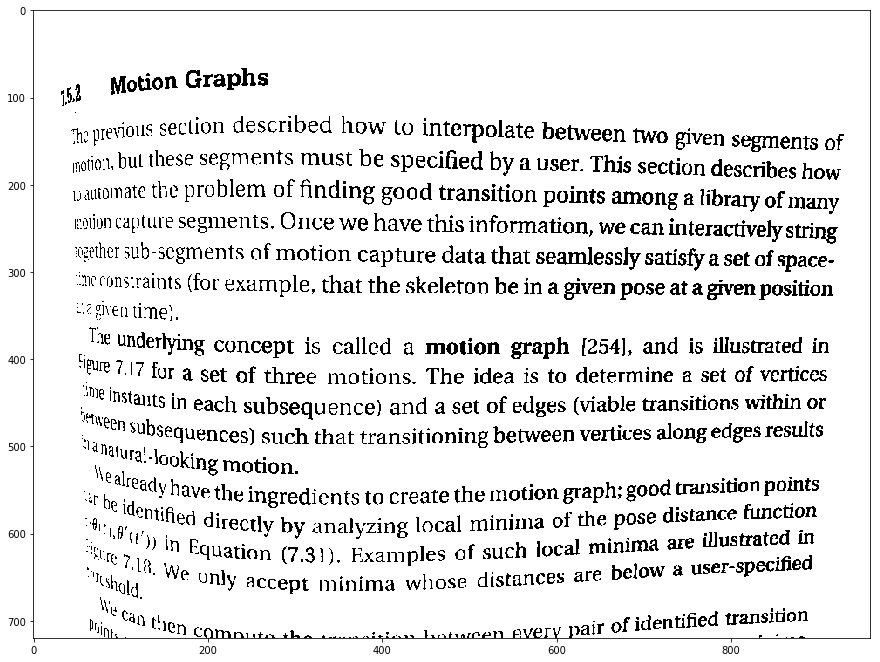

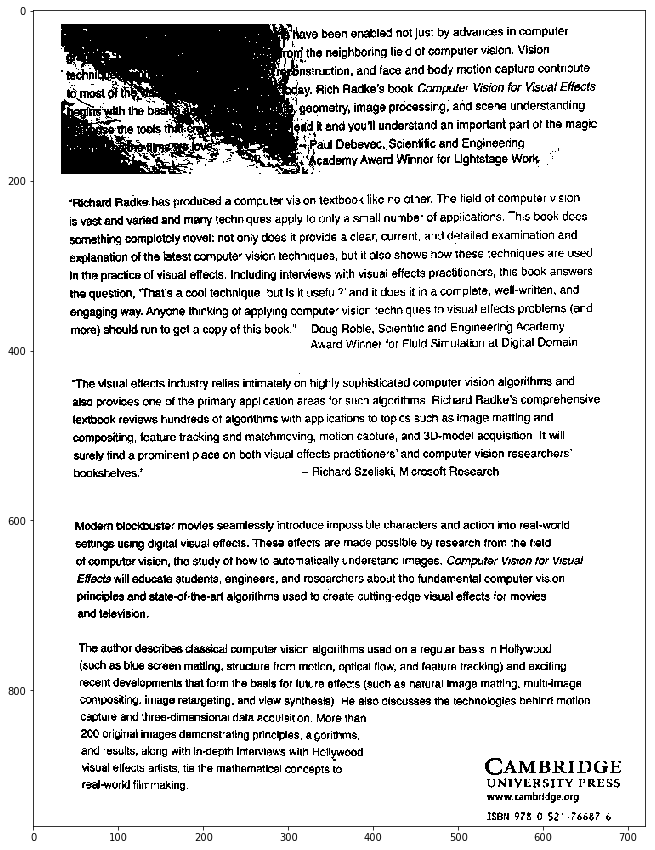

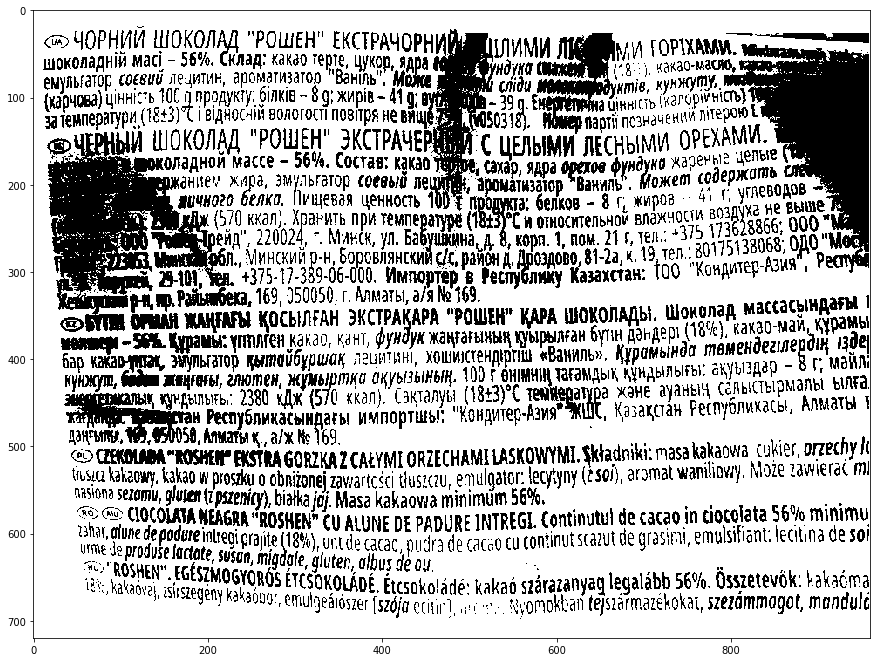

In [153]:
for img in imgs_out:
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')
    plt.show()

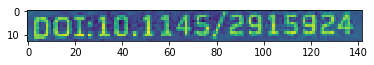

In [53]:
plt.imshow(img[bbox[0][0][1]:bbox[0][1][1],bbox[0][0][0]:bbox[0][1][0]])

In [30]:
th = [cv2.threshold(img, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) for img in gray_imgs]

In [36]:
th = [cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5) for img in gray_imgs]

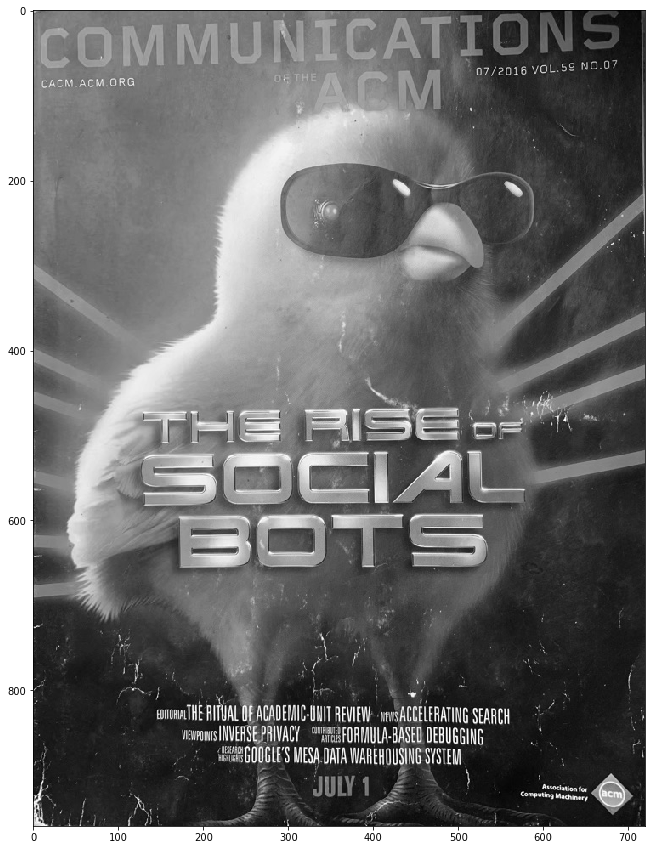

In [93]:
plt.figure(figsize=(15,15))
plt.imshow(gray_imgs[1], cmap='gray')

In [37]:
output = cv2.connectedComponents(th[0])

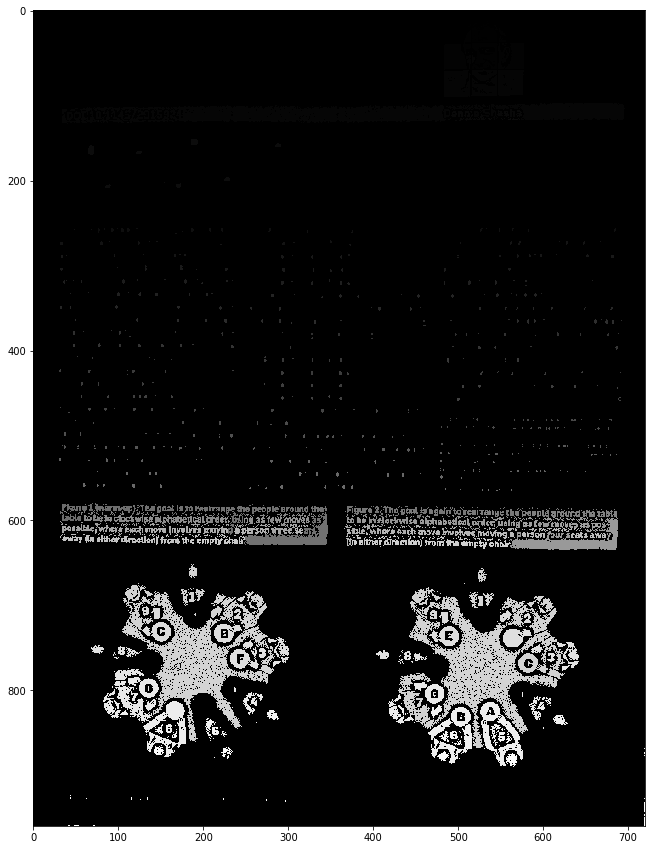

In [38]:
plt.figure(figsize=(15,15))
plt.imshow(output[1], cmap='gray')